In [1]:

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import config

matplotlib data path: /home/vlad/miniconda3/envs/TEST/lib/python3.9/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/vlad/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/vlad/.cache/matplotlib
Using fontManager instance from /home/vlad/.cache/matplotlib/fontlist-v390.json


In [3]:
# The model was trained in GoogleColab. Weights and configuration file are in 'lifecell' folder:
cfg = get_cfg()
cfg.merge_from_file("lifecell/final_model_config.yaml")

Loading config lifecell/final_model_config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [4]:
cfg.MODEL.WEIGHTS = "lifecell/model_final.pth"  # path to the trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[DetectionCheckpointer] Loading from lifecell/model_final.pth ...
[Checkpointer] Loading from lifecell/model_final.pth ...


In [4]:
# We need to register the dataset in order to use it with detectron2 API

dataDir=Path(config.TRAIN_VAL_IMAGES)
testDataDir=Path(config.TEST_IMAGES)
cfg = get_cfg()
register_coco_instances('train_data',{}, config.TRAIN_COCO_ANNOTATIONS, dataDir)
register_coco_instances('val_data',{}, config.VAL_COCO_ANNOTATIONS, dataDir)
register_coco_instances('test_data',{}, config.TEST_COCO_ANNOTATIONS, testDataDir)
val_metadata = MetadataCatalog.get('val_data')
val_ds = DatasetCatalog.get('val_data')


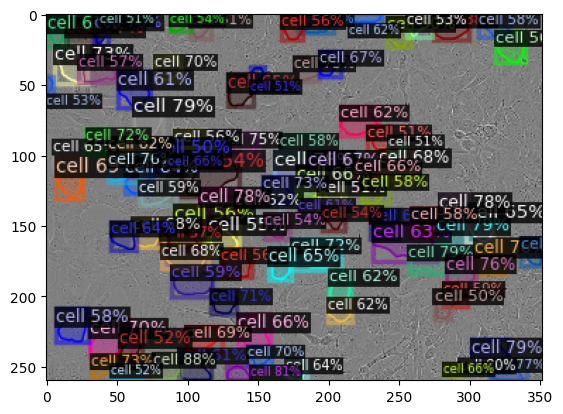

In [38]:
# Let's display some images with predictions

for d in random.sample(val_ds, 1):    # select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [8]:
# Calculate evaluation metrics
# SOTA result - 47.9 mask AP
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val_data", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val_data")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

# Our result - 12.9 mask AP

Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.

In [9]:
# Now we can visualize test images
test_metadata = MetadataCatalog.get('test_data')
test_ds = DatasetCatalog.get('test_data')

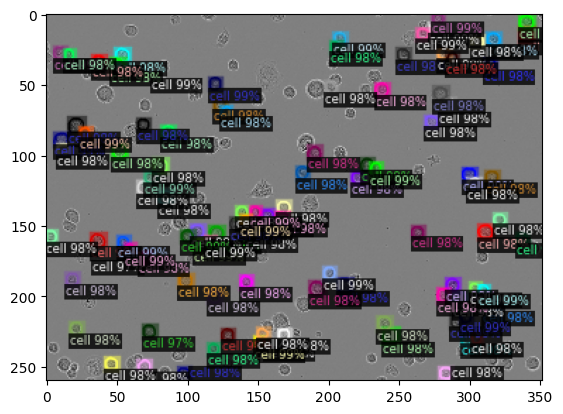

In [14]:
for d in random.sample(test_ds, 1):    # select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [15]:
# Segment all test images and save results 
import os

# Directory path to the input images folder
input_images_directory = "lifecell/images/livecell_test_images"

# Output directory where the segmented images will be saved
output_directory = "outputs/test_images_segmented"  
os.makedirs(output_directory, exist_ok=True)

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

Segmentation of all images completed.


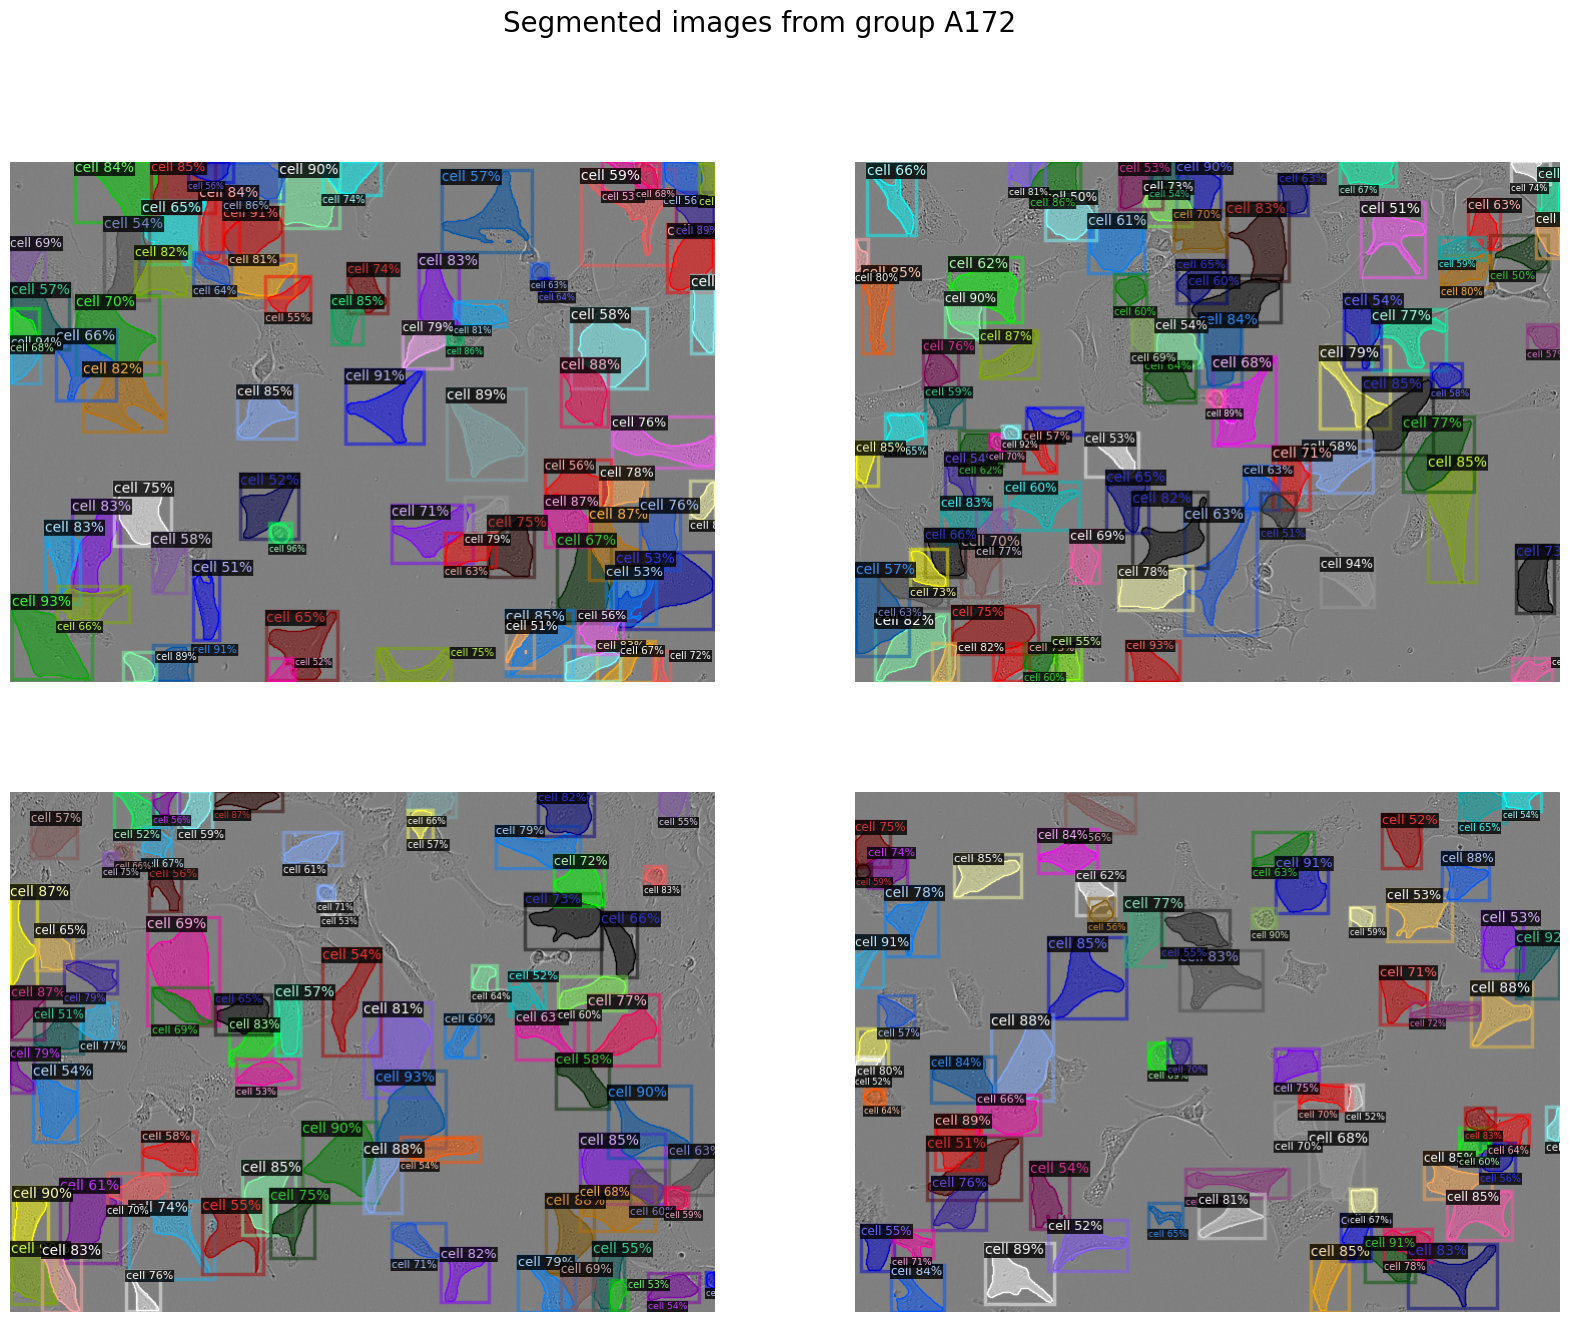

In [56]:
# We can visualize images from specific group

groups = ['A172', 'BT474', 'BV2', 'Huh7', 'MCF7', 'SHSY5Y', 'SkBr3', 'SKOV3']
random_group = random.choice(groups)

selected_group = [image_name for image_name in os.listdir(output_directory) if image_name.startswith(random_group)]

selected_images = random.sample(selected_group, 4)
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle(f"Segmented images from group {random_group}", fontsize=20)

for i, image_name in enumerate(selected_images):
    image_path = os.path.join(output_directory, image_name)
    image = cv2.imread(image_path)
    axs[i // 2, i % 2].imshow(image)
    axs[i // 2, i % 2].axis('off')

plt.show()


There are different ways to improve result
1) Different model architecture. We select model with ResNet-50 backbone. Deeper architecture (ResNet-101, for example) could give better results
2) Data Augmentations on train images
3) Hyperparameters tuning. Due to limited computational resources, we trained model with batch_size = 1 and number of ROI heads per image = 256. It can be too small for such images with lots of objects, and results would be better with this parameters increased.  